In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import plotly.io as pio
import plotly.graph_objs as go
import numpy as np
import torch
import os
from tqdm import tqdm
from common import _get_model, create_testloader, LOSS_FUNC
from matplotlib import pyplot as plt

DEFAULT_GRID_SIZE = 20
DEFAULT_BATCH_SIZE = 128

def set_weights(model, weights):
    weight_dict = {}
    idx = 0
    for key, param in model.state_dict().items():
        size = int(np.prod(param.shape))
        weight_dict[key] = torch.tensor(weights[idx : idx + size]).view(param.shape)
        idx += size

    model.load_state_dict(weight_dict)
    return model

In [2]:
batch_size = DEFAULT_BATCH_SIZE
subfolder = ""
grid_size = DEFAULT_GRID_SIZE
grid_save=True

In [3]:
path_grid_losses = None
path_grid_xx = None
path_grid_yy = None

m_0 = "fashion_mnist_classic_0_100_0005_00_32_10_SGD_spe3_model.pt"
m_5 = "fashion_mnist_classic_0_100_0005_05_32_10_SGD_spe3_model.pt"
m_9 = "fashion_mnist_classic_0_100_0005_09_32_10_SGD_spe3_model.pt"
w_0 = "fashion_mnist_classic_0_100_0005_00_32_10_SGD_spe3_weights.npy"
w_5 = "fashion_mnist_classic_0_100_0005_05_32_10_SGD_spe3_weights.npy"
w_9 = "fashion_mnist_classic_0_100_0005_09_32_10_SGD_spe3_weights.npy"

w_0 = np.load(w_0)
w_5 = np.load(w_5)
w_9 = np.load(w_9)

len_w = len(w_0)
print(w_0.shape)
print((w_0[0,:] == w_9[0,:]).all())

(31, 61706)
True


In [ ]:
"""
path_grid_losses = "fashion_mnist_classic_0_100_0005_00_32_6_SGD_spe3_val_model_grid_losses.npy"
path_grid_xx = "fashion_mnist_classic_0_100_0005_00_32_6_SGD_spe3_val_model_grid_xx.npy"
path_grid_yy = "fashion_mnist_classic_0_100_0005_00_32_6_SGD_spe3_val_model_grid_yy.npy"
"""

# 1) PCA fit transform on individually, translation to origin point, pca inverse = pca9 (correct)

In [ ]:
loaded_weights_np = np.concatenate([w_0, w_5, w_9], axis=0)

#scaler = StandardScaler()

#standardized_weights0 = scaler.fit_transform(w_0)
#standardized_weights05 = scaler.transform(w_5)
#standardized_weights09 = scaler.transform(w_9)
#all_weights = np.concatenate([standardized_weights0, standardized_weights05, standardized_weights09], axis=0)

#all_weights = scaler.fit_transform(loaded_weights_np)

pca = PCA(n_components=2)
#pca.fit(all_weights)

#projected_weights0 = pca.transform(standardized_weights0)
#projected_weights5 = pca.transform(standardized_weights05)
#projected_weights9 = pca.transform(standardized_weights09)

#projected_weights0 = pca.transform(all_weights[:len_w,:])
#projected_weights5 = pca.transform(all_weights[len_w:2*len_w,:])
#projected_weights9 = pca.transform(all_weights[2*len_w:,:])

projected_weights0 = pca.fit_transform(w_0)
projected_weights5 = pca.fit_transform(w_5)
projected_weights9 = pca.fit_transform(w_9) # pca inverse will be pca9

print(projected_weights0[0,:], projected_weights5[0,:], projected_weights9[0,:])
print(projected_weights0[-1,:], projected_weights5[-1,:], projected_weights9[-1,:])

plt.plot(projected_weights0[:,0],projected_weights0[:,1], marker="x")
plt.plot(projected_weights5[:,0],projected_weights5[:,1], marker="s")
plt.plot(projected_weights9[:,0],projected_weights9[:,1], marker="o")
plt.show()

reduced_weights = [projected_weights0, projected_weights5, projected_weights9]

loaded_weights_np = [w_0, w_5, w_9]

classic_model = m_0

In [ ]:
projected_weights0[0], projected_weights5[0], projected_weights9[0]

In [ ]:
projected_weights5 = projected_weights5 + (projected_weights0[0] - projected_weights5[0])
projected_weights9 = projected_weights9 + (projected_weights0[0] - projected_weights9[0])
plt.plot(projected_weights0[:,0],projected_weights0[:,1], marker="x")
plt.plot(projected_weights5[:,0],projected_weights5[:,1], marker="s")
plt.plot(projected_weights9[:,0],projected_weights9[:,1], marker="o")
plt.show()

reduced_weights = [projected_weights0, projected_weights5, projected_weights9]

loaded_weights_np = [w_0, w_5, w_9]

classic_model = m_0

# 2) PCA fit transform on individually, finding translation and rotation to go to pca 0 space from pca space 5 and pca space 9, pca inverse = pca0  (incorect to redo)

In [ ]:
pca = PCA(n_components=2)

projected_weights5 = pca.fit_transform(w_5)
projected_weights9 = pca.fit_transform(w_9)
projected_weights0 = pca.fit_transform(w_0) # pca inverse should be pca 0

pca_0 = PCA(n_components=2)
pca_0.fit(w_0)
pca_5 = PCA(n_components=2)
pca_5.fit(w_5)
pca_9 = PCA(n_components=2)
pca_9.fit(w_9)

E_0 = pca_0.components_

E_5 = pca_5.components_
T_5_to_0 = np.dot(E_5, E_0.T)

E_9 = pca_9.components_
T_9_to_0 = np.dot(E_9, E_0.T)

projected_weights5_transformed = np.dot(projected_weights5, T_5_to_0)
projected_weights9_transformed = np.dot(projected_weights9, T_9_to_0)
projected_weights0 = pca_0.transform(w_0)

plt.plot(projected_weights0[:,0],projected_weights0[:,1], marker="x")
plt.plot(projected_weights5_transformed[:,0],projected_weights5_transformed[:,1], marker="s")
plt.plot(projected_weights9_transformed[:,0],projected_weights9_transformed[:,1], marker="o")
plt.show()

In [ ]:
projected_weights5_transformed = projected_weights5_transformed + (projected_weights0[0] - projected_weights5_transformed[0])
projected_weights9_transformed = projected_weights9_transformed + (projected_weights0[0] - projected_weights9_transformed[0])

plt.plot(projected_weights0[:,0],projected_weights0[:,1], marker="x")
plt.plot(projected_weights5_transformed[:,0],projected_weights5_transformed[:,1], marker="s")
plt.plot(projected_weights9_transformed[:,0],projected_weights9_transformed[:,1], marker="o")
plt.show()

reduced_weights = [projected_weights0, projected_weights5_transformed, projected_weights9_transformed]

loaded_weights_np = [w_0, w_5, w_9]

classic_model = m_0

# 3) PCA fit transform individually, finding translation and rotation to go to pca 9 space from pca space 5 and pca space 0, pca inverse = pca9 (correct)

In [ ]:
pca = PCA(n_components=2)

projected_weights0 = pca.fit_transform(w_0)
projected_weights5 = pca.fit_transform(w_5)
projected_weights9 = pca.fit_transform(w_9)

pca_0 = PCA(n_components=2)  # PCA inverse should be pca_9 as it is used as base (correct in this case)
pca_0.fit(w_0)
pca_5 = PCA(n_components=2)
pca_5.fit(w_5)
pca_9 = PCA(n_components=2)
pca_9.fit(w_9)

E_0 = pca_0.components_
E_5 = pca_5.components_
E_9 = pca_9.components_

T_5_to_9 = np.dot(E_5, E_9.T)
T_0_to_9 = np.dot(E_0, E_9.T)

projected_weights5_transformed = np.dot(projected_weights5, T_5_to_9)
projected_weights0_transformed = np.dot(projected_weights9, T_0_to_9)
projected_weights9 = pca_9.transform(w_9)

plt.plot(projected_weights0_transformed[:,0],projected_weights0_transformed[:,1], marker="x")
plt.plot(projected_weights5_transformed[:,0],projected_weights5_transformed[:,1], marker="s")
plt.plot(projected_weights9[:,0],projected_weights9[:,1], marker="o")
plt.show()

In [ ]:
projected_weights5_transformed = projected_weights5_transformed + (projected_weights9[0] - projected_weights5_transformed[0])
projected_weights0_transformed = projected_weights0_transformed + (projected_weights9[0] - projected_weights0_transformed[0])

plt.plot(projected_weights0_transformed[:,0],projected_weights0_transformed[:,1], marker="x")
plt.plot(projected_weights5_transformed[:,0],projected_weights5_transformed[:,1], marker="s")
plt.plot(projected_weights9[:,0],projected_weights9[:,1], marker="o")
plt.show()

reduced_weights = [projected_weights0_transformed, projected_weights5_transformed, projected_weights9]

loaded_weights_np = [w_0, w_5, w_9]

m_9 = "fashion_mnist_classic_0_100_0005_09_32_10_SGD_spe3_model.pt"
classic_model = m_9

# 4) PCA fit transform all, pca inverse = pca all

In [ ]:
pca = PCA(n_components=2)
loaded_weights_np = np.concatenate([w_0, w_5, w_9], axis=0)

red_w = pca.fit_transform(loaded_weights_np) # PCA inverse correct

red_0 = red_w[:len_w,:]
red_5 = red_w[len_w:2*len_w,:]
red_9= red_w[2*len_w:,:]

plt.plot(red_0[:,0],red_0[:,1], marker="x")
plt.plot(red_5[:,0],red_5[:,1], marker="s")
plt.plot(red_9[:,0],red_9[:,1], marker="o")
plt.show()

reduced_weights = [red_0, red_5, red_9]

loaded_weights_np = [w_0, w_5, w_9]

classic_model = m_0

# 5) PCA fit individually, do a landscape for each, save the global min for each, on the 2d plot, show trajectories and their mins + possible rescale trajectories and mins so they start at the same point

In [4]:
pca = PCA(n_components=2)

projected_weights0 = pca.fit_transform(w_0)

reduced_weights = [projected_weights0]

loaded_weights_np = [w_0]

classic_model = m_0

landscape 0

In [5]:
_min_w = 99999999
_max_w = 0

for i, w in enumerate(reduced_weights):

    _min = np.min(w)
    _max = np.max(w)

    if _min < _min_w:
        _min_w = _min
    if _max > _max_w:
        _max_w = _max 

_min_w = _min_w -1
_max_w = _max_w +1

if path_grid_losses is None and path_grid_xx is None and path_grid_yy is None:
    grid_range_x = np.linspace(_min-1*(_max-_min), _max+1*(_max-_min), grid_size)
    grid_range_y = np.linspace(_min-1*(_max-_min), _max+1*(_max-_min), grid_size)

    xx, yy = np.meshgrid(grid_range_x, grid_range_y)
    xx_0 = xx
    yy_0 = yy

    grid_points = np.column_stack((xx.ravel(), yy.ravel()))
    grid_weights_0 = pca.inverse_transform(grid_points)

for i, rw in enumerate(reduced_weights):
    #if i != 0:
        #loaded_weights_np[i] = pca.inverse_transform(rw)
    loaded_weights_np[i] = pca.inverse_transform(rw)

loader = create_testloader(classic_model, batch_size)
if "alt_model" in classic_model:
    model = _get_model(classic_model, LOSS_FUNC, alt_model=True)
else:
    model = _get_model(classic_model, LOSS_FUNC, alt_model=False)

model.load_state_dict(torch.load(classic_model))
model.eval()

# Grid training
if path_grid_losses is None and path_grid_xx is None and path_grid_yy is None:


    grid_losses_0 = []

    progress_bar = tqdm(
        total=len(grid_weights_0),
        desc="Computing loss of grid weights",
        unit="model_weights",
    )

    with torch.no_grad():
        for weights in grid_weights_0:
            model = set_weights(model, weights)

            running_loss = 0.0
            for inputs, labels in loader:
                outputs = model(inputs)
                loss = LOSS_FUNC(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

            grid_losses_0.append(running_loss / len(loader.dataset))
            progress_bar.update(1)
            progress_bar.set_postfix(grid_loss=grid_losses_0[-1])

    progress_bar.close()

    grid_losses_0 = np.array(grid_losses_0).reshape(grid_size, grid_size)

    if grid_save:

        model_filename = os.path.basename(classic_model)
        model_basename, _ = os.path.splitext(model_filename)

        if len(subfolder) > 0:
            if not os.path.exists(subfolder):
                os.makedirs(subfolder)

        np.save(f"{model_basename}_grid_losses.npy", grid_losses_0)
        np.save(f"{model_basename}_grid_xx.npy", xx_0)
        np.save(f"{model_basename}_grid_yy.npy", yy_0)
        print(f"Saved grid losses to: {f'{model_basename}_grid_losses_0.npy'}")
        print(f"Saved grid xx to: {f'{model_basename}_grid_xx_0.npy'}")
        print(f"Saved grid yy to: {f'{model_basename}_grid_yy_0.npy'}")
else:
    xx = np.load(path_grid_xx)
    yy = np.load(path_grid_yy)
    grid_losses = np.load(path_grid_losses)
    print("Loadded grid_losses, grid_xx and grid_yy")

# trajectories evaluationa
trajectories_loss_reevaluted_0 = []
for w in loaded_weights_np:
    trajectory_loss_reevaluted = []
    progress_bar2 = tqdm(
        total=len(w),
        desc="Computing loss of trajectory weights",
        unit="model_weights",
    )

    with torch.no_grad():
        for weights in w:
            model = set_weights(model, weights)

            running_loss = 0.0
            for inputs, labels in loader:
                outputs = model(inputs)
                loss = LOSS_FUNC(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

            trajectory_loss_reevaluted.append(running_loss / len(loader.dataset))
            progress_bar2.update(1)
            progress_bar2.set_postfix(trajectory_loss=trajectory_loss_reevaluted[-1])

    progress_bar2.close()
    trajectories_loss_reevaluted_0.append(trajectory_loss_reevaluted)

Created MNIST/FASHION_MNIST CNN
LeNet5 using loss: <function nll_loss at 0x7fe3b8f0bd00>


Computing loss of grid weights: 100%|██████████████████████| 400/400 [17:40<00:00,  2.65s/model_weights, grid_loss=3.83]


Saved grid losses to: fashion_mnist_classic_0_100_0005_00_32_10_SGD_spe3_model_grid_losses_0.npy
Saved grid xx to: fashion_mnist_classic_0_100_0005_00_32_10_SGD_spe3_model_grid_xx_0.npy
Saved grid yy to: fashion_mnist_classic_0_100_0005_00_32_10_SGD_spe3_model_grid_yy_0.npy


Computing loss of trajectory weights: 100%|███████████| 31/31 [01:26<00:00,  2.78s/model_weights, trajectory_loss=0.368]


In [7]:
# do landscape save the global min for 0

projected_weights5 = pca.fit_transform(w_5)

reduced_weights = [projected_weights5]

loaded_weights_np = [w_5]

classic_model = m_5

landscape 5

In [8]:
_min_w = 99999999
_max_w = 0

for i, w in enumerate(reduced_weights):

    _min = np.min(w)
    _max = np.max(w)

    if _min < _min_w:
        _min_w = _min
    if _max > _max_w:
        _max_w = _max 

_min_w = _min_w -1
_max_w = _max_w +1

if path_grid_losses is None and path_grid_xx is None and path_grid_yy is None:
    grid_range_x = np.linspace(_min-1*(_max-_min), _max+1*(_max-_min), grid_size)
    grid_range_y = np.linspace(_min-1*(_max-_min), _max+1*(_max-_min), grid_size)

    xx, yy = np.meshgrid(grid_range_x, grid_range_y)
    xx_5 = xx
    yy_5 = yy

    grid_points = np.column_stack((xx.ravel(), yy.ravel()))
    grid_weights_5 = pca.inverse_transform(grid_points)

for i, rw in enumerate(reduced_weights):
    #if i != 0:
        #loaded_weights_np[i] = pca.inverse_transform(rw)
    loaded_weights_np[i] = pca.inverse_transform(rw)

loader = create_testloader(classic_model, batch_size)
if "alt_model" in classic_model:
    model = _get_model(classic_model, LOSS_FUNC, alt_model=True)
else:
    model = _get_model(classic_model, LOSS_FUNC, alt_model=False)

model.load_state_dict(torch.load(classic_model))
model.eval()

# Grid training
if path_grid_losses is None and path_grid_xx is None and path_grid_yy is None:


    grid_losses_5 = []

    progress_bar = tqdm(
        total=len(grid_weights_5),
        desc="Computing loss of grid weights",
        unit="model_weights",
    )

    with torch.no_grad():
        for weights in grid_weights_5:
            model = set_weights(model, weights)

            running_loss = 0.0
            for inputs, labels in loader:
                outputs = model(inputs)
                loss = LOSS_FUNC(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

            grid_losses_5.append(running_loss / len(loader.dataset))
            progress_bar.update(1)
            progress_bar.set_postfix(grid_loss=grid_losses_5[-1])

    progress_bar.close()

    grid_losses_5 = np.array(grid_losses_5).reshape(grid_size, grid_size)

    if grid_save:

        model_filename = os.path.basename(classic_model)
        model_basename, _ = os.path.splitext(model_filename)

        if len(subfolder) > 0:
            if not os.path.exists(subfolder):
                os.makedirs(subfolder)

        np.save(f"{model_basename}_grid_losses.npy", grid_losses_5)
        np.save(f"{model_basename}_grid_xx.npy", xx_5)
        np.save(f"{model_basename}_grid_yy.npy", yy_5)
        print(f"Saved grid losses to: {f'{model_basename}_grid_losses_5.npy'}")
        print(f"Saved grid xx to: {f'{model_basename}_grid_xx_5.npy'}")
        print(f"Saved grid yy to: {f'{model_basename}_grid_yy_5.npy'}")
else:
    xx = np.load(path_grid_xx)
    yy = np.load(path_grid_yy)
    grid_losses = np.load(path_grid_losses)
    print("Loadded grid_losses, grid_xx and grid_yy")

# trajectories evaluationa
trajectories_loss_reevaluted_5 = []
for w in loaded_weights_np:
    trajectory_loss_reevaluted = []
    progress_bar2 = tqdm(
        total=len(w),
        desc="Computing loss of trajectory weights",
        unit="model_weights",
    )

    with torch.no_grad():
        for weights in w:
            model = set_weights(model, weights)

            running_loss = 0.0
            for inputs, labels in loader:
                outputs = model(inputs)
                loss = LOSS_FUNC(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

            trajectory_loss_reevaluted.append(running_loss / len(loader.dataset))
            progress_bar2.update(1)
            progress_bar2.set_postfix(trajectory_loss=trajectory_loss_reevaluted[-1])

    progress_bar2.close()
    trajectories_loss_reevaluted_5.append(trajectory_loss_reevaluted)

Created MNIST/FASHION_MNIST CNN
LeNet5 using loss: <function nll_loss at 0x7fe3b8f0bd00>


Computing loss of grid weights: 100%|████████████████████████| 400/400 [16:11<00:00,  2.43s/model_weights, grid_loss=10]


Saved grid losses to: fashion_mnist_classic_0_100_0005_05_32_10_SGD_spe3_model_grid_losses_5.npy
Saved grid xx to: fashion_mnist_classic_0_100_0005_05_32_10_SGD_spe3_model_grid_xx_5.npy
Saved grid yy to: fashion_mnist_classic_0_100_0005_05_32_10_SGD_spe3_model_grid_yy_5.npy


Computing loss of trajectory weights: 100%|███████████| 31/31 [00:59<00:00,  1.93s/model_weights, trajectory_loss=0.318]


In [9]:
projected_weights9 = pca.fit_transform(w_9)

reduced_weights = [projected_weights9]

loaded_weights_np = [w_9]

classic_model = m_9

landscape 9

In [10]:
_min_w = 99999999
_max_w = 0

for i, w in enumerate(reduced_weights):

    _min = np.min(w)
    _max = np.max(w)

    if _min < _min_w:
        _min_w = _min
    if _max > _max_w:
        _max_w = _max 

_min_w = _min_w -1
_max_w = _max_w +1

if path_grid_losses is None and path_grid_xx is None and path_grid_yy is None:
    grid_range_x = np.linspace(_min-1*(_max-_min), _max+1*(_max-_min), grid_size)
    grid_range_y = np.linspace(_min-1*(_max-_min), _max+1*(_max-_min), grid_size)

    xx, yy = np.meshgrid(grid_range_x, grid_range_y)
    xx_9 = xx
    yy_9 = yy

    grid_points = np.column_stack((xx.ravel(), yy.ravel()))
    grid_weights_9 = pca.inverse_transform(grid_points)

for i, rw in enumerate(reduced_weights):
    #if i != 0:
        #loaded_weights_np[i] = pca.inverse_transform(rw)
    loaded_weights_np[i] = pca.inverse_transform(rw)

loader = create_testloader(classic_model, batch_size)
if "alt_model" in classic_model:
    model = _get_model(classic_model, LOSS_FUNC, alt_model=True)
else:
    model = _get_model(classic_model, LOSS_FUNC, alt_model=False)

model.load_state_dict(torch.load(classic_model))
model.eval()

# Grid training
if path_grid_losses is None and path_grid_xx is None and path_grid_yy is None:


    grid_losses_9 = []

    progress_bar = tqdm(
        total=len(grid_weights_9),
        desc="Computing loss of grid weights",
        unit="model_weights",
    )

    with torch.no_grad():
        for weights in grid_weights_9:
            model = set_weights(model, weights)

            running_loss = 0.0
            for inputs, labels in loader:
                outputs = model(inputs)
                loss = LOSS_FUNC(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

            grid_losses_9.append(running_loss / len(loader.dataset))
            progress_bar.update(1)
            progress_bar.set_postfix(grid_loss=grid_losses_9[-1])

    progress_bar.close()

    grid_losses_9 = np.array(grid_losses_9).reshape(grid_size, grid_size)

    if grid_save:

        model_filename = os.path.basename(classic_model)
        model_basename, _ = os.path.splitext(model_filename)

        if len(subfolder) > 0:
            if not os.path.exists(subfolder):
                os.makedirs(subfolder)

        np.save(f"{model_basename}_grid_losses.npy", grid_losses_9)
        np.save(f"{model_basename}_grid_xx.npy", xx_9)
        np.save(f"{model_basename}_grid_yy.npy", yy_9)
        print(f"Saved grid losses to: {f'{model_basename}_grid_losses_9.npy'}")
        print(f"Saved grid xx to: {f'{model_basename}_grid_xx_9.npy'}")
        print(f"Saved grid yy to: {f'{model_basename}_grid_yy_9.npy'}")
else:
    xx = np.load(path_grid_xx)
    yy = np.load(path_grid_yy)
    grid_losses = np.load(path_grid_losses)
    print("Loadded grid_losses, grid_xx and grid_yy")

# trajectories evaluationa
trajectories_loss_reevaluted_9 = []
for w in loaded_weights_np:
    trajectory_loss_reevaluted = []
    progress_bar2 = tqdm(
        total=len(w),
        desc="Computing loss of trajectory weights",
        unit="model_weights",
    )

    with torch.no_grad():
        for weights in w:
            model = set_weights(model, weights)

            running_loss = 0.0
            for inputs, labels in loader:
                outputs = model(inputs)
                loss = LOSS_FUNC(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

            trajectory_loss_reevaluted.append(running_loss / len(loader.dataset))
            progress_bar2.update(1)
            progress_bar2.set_postfix(trajectory_loss=trajectory_loss_reevaluted[-1])

    progress_bar2.close()
    trajectories_loss_reevaluted_9.append(trajectory_loss_reevaluted)

Created MNIST/FASHION_MNIST CNN
LeNet5 using loss: <function nll_loss at 0x7fe3b8f0bd00>


Computing loss of grid weights: 100%|█████████████████████| 400/400 [1:18:50<00:00, 11.83s/model_weights, grid_loss=173]


Saved grid losses to: fashion_mnist_classic_0_100_0005_09_32_10_SGD_spe3_model_grid_losses_9.npy
Saved grid xx to: fashion_mnist_classic_0_100_0005_09_32_10_SGD_spe3_model_grid_xx_9.npy
Saved grid yy to: fashion_mnist_classic_0_100_0005_09_32_10_SGD_spe3_model_grid_yy_9.npy


Computing loss of trajectory weights: 100%|███████████| 31/31 [06:33<00:00, 12.69s/model_weights, trajectory_loss=0.253]


9 7 0.35871151843070986
9 7 0.3054031849861145
9 7 0.260352781021595


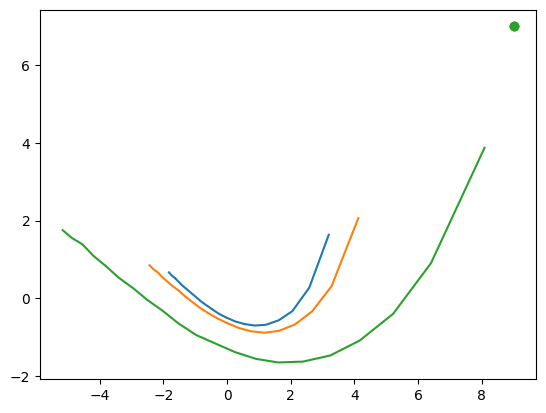

In [15]:
_min_x_0, _min_y_0 = np.unravel_index(np.argmin(grid_losses_0), grid_losses_0.shape)
_min_x_5, _min_y_5 = np.unravel_index(np.argmin(grid_losses_5), grid_losses_5.shape)
_min_x_9, _min_y_9 = np.unravel_index(np.argmin(grid_losses_9), grid_losses_9.shape)
print(_min_x_0, _min_y_0, np.min(grid_losses_0))
print(_min_x_5, _min_y_5, np.min(grid_losses_5))
print(_min_x_9, _min_y_9, np.min(grid_losses_9))
plt.plot(projected_weights0[:,0], projected_weights0[:,1])
plt.plot(projected_weights5[:,0], projected_weights5[:,1])
plt.plot(projected_weights9[:,0], projected_weights9[:,1])
plt.scatter(_min_x_0, _min_y_0)
plt.scatter(_min_x_5, _min_y_5)
plt.scatter(_min_x_9, _min_y_9)
plt.show()

global landscape

In [16]:
pca = PCA(n_components=2)

projected_weights = pca.fit_transform(np.concatenate([w_0, w_5, w_9], axis = 0))

red_0 = projected_weights[:len_w,:]
red_5 = projected_weights[len_w:2*len_w,:]
red_9= projected_weights[2*len_w:,:]

reduced_weights = [red_0, red_5, red_9]

loaded_weights_np = [w_0, w_5, w_9]

classic_model = m_0

In [17]:
_min_w = 99999999
_max_w = 0

for i, w in enumerate(reduced_weights):

    _min = np.min(w)
    _max = np.max(w)

    if _min < _min_w:
        _min_w = _min
    if _max > _max_w:
        _max_w = _max 

_min_w = _min_w -1
_max_w = _max_w +1

if path_grid_losses is None and path_grid_xx is None and path_grid_yy is None:
    grid_range_x = np.linspace(_min-1*(_max-_min), _max+1*(_max-_min), grid_size)
    grid_range_y = np.linspace(_min-1*(_max-_min), _max+1*(_max-_min), grid_size)

    xx, yy = np.meshgrid(grid_range_x, grid_range_y)

    grid_points = np.column_stack((xx.ravel(), yy.ravel()))
    grid_weights = pca.inverse_transform(grid_points)

for i, rw in enumerate(reduced_weights):
    #if i != 0:
        #loaded_weights_np[i] = pca.inverse_transform(rw)
    loaded_weights_np[i] = pca.inverse_transform(rw)

loader = create_testloader(classic_model, batch_size)
if "alt_model" in classic_model:
    model = _get_model(classic_model, LOSS_FUNC, alt_model=True)
else:
    model = _get_model(classic_model, LOSS_FUNC, alt_model=False)

model.load_state_dict(torch.load(classic_model))
model.eval()

# Grid training
if path_grid_losses is None and path_grid_xx is None and path_grid_yy is None:


    grid_losses = []

    progress_bar = tqdm(
        total=len(grid_weights),
        desc="Computing loss of grid weights",
        unit="model_weights",
    )

    with torch.no_grad():
        for weights in grid_weights:
            model = set_weights(model, weights)

            running_loss = 0.0
            for inputs, labels in loader:
                outputs = model(inputs)
                loss = LOSS_FUNC(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

            grid_losses.append(running_loss / len(loader.dataset))
            progress_bar.update(1)
            progress_bar.set_postfix(grid_loss=grid_losses[-1])

    progress_bar.close()

    grid_losses = np.array(grid_losses).reshape(grid_size, grid_size)

    if grid_save:

        model_filename = os.path.basename(classic_model)
        model_basename, _ = os.path.splitext(model_filename)

        if len(subfolder) > 0:
            if not os.path.exists(subfolder):
                os.makedirs(subfolder)

        np.save(f"{model_basename}_grid_losses.npy", grid_losses)
        np.save(f"{model_basename}_grid_xx.npy", xx)
        np.save(f"{model_basename}_grid_yy.npy", yy)
        print(f"Saved grid losses to: {f'{model_basename}_grid_losses.npy'}")
        print(f"Saved grid xx to: {f'{model_basename}_grid_xx.npy'}")
        print(f"Saved grid yy to: {f'{model_basename}_grid_yy.npy'}")
else:
    xx = np.load(path_grid_xx)
    yy = np.load(path_grid_yy)
    grid_losses = np.load(path_grid_losses)
    print("Loadded grid_losses, grid_xx and grid_yy")

# trajectories evaluationa
trajectories_loss_reevaluted = []
for w in loaded_weights_np:
    trajectory_loss_reevaluted = []
    progress_bar2 = tqdm(
        total=len(w),
        desc="Computing loss of trajectory weights",
        unit="model_weights",
    )

    with torch.no_grad():
        for weights in w:
            model = set_weights(model, weights)

            running_loss = 0.0
            for inputs, labels in loader:
                outputs = model(inputs)
                loss = LOSS_FUNC(outputs, labels)
                running_loss += loss.item() * inputs.size(0)

            trajectory_loss_reevaluted.append(running_loss / len(loader.dataset))
            progress_bar2.update(1)
            progress_bar2.set_postfix(trajectory_loss=trajectory_loss_reevaluted[-1])

    progress_bar2.close()
    trajectories_loss_reevaluted.append(trajectory_loss_reevaluted)

Created MNIST/FASHION_MNIST CNN
LeNet5 using loss: <function nll_loss at 0x7fe3b8f0bd00>


Computing loss of grid weights: 100%|██████████████████████| 400/400 [14:15<00:00,  2.14s/model_weights, grid_loss=55.2]


Saved grid losses to: fashion_mnist_classic_0_100_0005_00_32_10_SGD_spe3_model_grid_losses.npy
Saved grid xx to: fashion_mnist_classic_0_100_0005_00_32_10_SGD_spe3_model_grid_xx.npy
Saved grid yy to: fashion_mnist_classic_0_100_0005_00_32_10_SGD_spe3_model_grid_yy.npy


Computing loss of trajectory weights: 100%|███████████| 31/31 [01:20<00:00,  2.59s/model_weights, trajectory_loss=0.293]


In [24]:
_min_x, _min_y = np.unravel_index(np.argmin(grid_losses), grid_losses.shape)
print(_min_x, _min_y)

9 12


In [21]:
new_traj = [trajectories_loss_reevaluted_0[0], trajectories_loss_reevaluted_5[0], trajectories_loss_reevaluted_9[0]]

In [39]:
surface = go.Surface(
    x=xx,
    y=yy,
    z=grid_losses,
    opacity=0.8,
    name="grid point",
    coloraxis="coloraxis",
    colorscale="Viridis",
)

trajectory_names = [
    "Classic SGD m=0.0",
    "Classic SGD m=0.5",
    "Classic SGD m=0.9",
]
trajectory_colors = ['orange', 'green', 'blue', 'yellow', 'purple', 'cyan', 'magenta']  # Define more colors if you have more trajectories
trajectories = []
for i, (rw, tl) in enumerate(zip(reduced_weights, trajectories_loss_reevaluted)):
    traj = go.Scatter3d(
        x=rw[:, 0],
        y=rw[:, 1],
        z=tl,
        mode="markers+lines",
        line=dict(color=trajectory_colors[i % len(trajectory_colors)]),
        marker=dict(color=trajectory_colors[i % len(trajectory_colors)], size=5),
        name=trajectory_names[i],
    )
    trajectories.append(traj)

layout = go.Layout(
    scene=dict(xaxis_title="PC1", yaxis_title="PC2", zaxis_title=" Loss", zaxis=dict(type='log')),
    coloraxis=dict(colorbar=dict(title="Loss magnitude"), 
                   colorscale="Viridis",
                   cmin=np.log10(grid_losses.min()),  
                    cmax=np.log10(grid_losses.max()),
    ),
)   

fig = go.Figure(data=[surface]+ trajectories, layout=layout)

fig.data[0].update(contours_z=dict(show=True, usecolormap=True,
                              highlightcolor="limegreen", project_z=True))

_min_x, _min_y = np.unravel_index(np.argmin(grid_losses), grid_losses.shape)
min_point = go.Scatter3d(
    x=[xx[_min_x, _min_y]],
    y=[yy[_min_x, _min_y]],
    z=[grid_losses[_min_x, _min_y]],
    mode='markers',
    marker=dict(
        size=5,
        color='red',
    ),
    name="global minimum"
)

fig.add_trace(min_point)

fig.update_layout(legend=dict(orientation="v", x=0, y=0.5))

fig.show()

In [27]:
new_reduced_weights = [projected_weights0,projected_weights5,projected_weights9]

In [28]:
fig2 = go.Figure(data=[go.Contour(x=xx.flatten(), y=yy.flatten(), z=np.log10(grid_losses.flatten()), 
                                  name= "grid point", colorscale='Viridis')])
labels = ["Start Point"] + ["Trajectory Point"] * (len(trajectory_loss_reevaluted) - 2) + ["End Point"]
sizes = [8] + [5] * (len(trajectory_loss_reevaluted) - 2) + [8]

trajectories = []
for i, rw in enumerate(new_reduced_weights):
    traj = go.Scatter(
        x=rw[:, 0],  # x-axis
        y=rw[:, 1],  # y-axis
        mode="markers+lines",
        line=dict(color=trajectory_colors[i % len(trajectory_colors)]),
        marker=dict(color=trajectory_colors[i % len(trajectory_colors)], size=sizes),
        name=trajectory_names[i],
        text=[f"{label}<br>Loss: {loss}" for label, loss in zip(labels, trajectories_loss_reevaluted[i])],
        hovertemplate='%{text}',
    )
    trajectories.append(traj)

for traj in trajectories:
    fig2.add_trace(traj)

fig2.update_layout(
    title='Contour Plot with trajectories Projection',
    xaxis_title='PC1',
    yaxis_title='PC2',
    legend=dict(orientation="v", x=1, y=1)
)

min_point = go.Scatter(
    x=[xx[_min_x, _min_y]],
    y=[yy[_min_x, _min_y]],
    mode='markers',
    marker=dict(
        size=7,
        color='red',
        symbol='star',
    ),
    name="global minimum",
    text=[str(np.min(grid_losses))],
    hovertemplate='Loss: %{text}'
)

fig2.add_trace(min_point)

min_point_0 = go.Scatter(
    x=[xx_0[_min_x_0, _min_y_0]],
    y=[yy_0[_min_x_0, _min_y_0]],
    mode='markers',
    marker=dict(
        size=7,
        color='red',
        symbol='cross',
    ),
    name="min 0",
    text=[str(np.min(grid_losses_0))],
    hovertemplate='Loss: %{text}'
)

fig2.add_trace(min_point_0)

min_point_5 = go.Scatter(
    x=[xx_5[_min_x_5, _min_y_5]],
    y=[yy_5[_min_x_5, _min_y_5]],
    mode='markers',
    marker=dict(
        size=7,
        color='red',
        symbol='square',
    ),
    name="min 5",
    text=[str(np.min(grid_losses_5))],
    hovertemplate='Loss: %{text}'
)

fig2.add_trace(min_point_5)

min_point_9 = go.Scatter(
    x=[xx_9[_min_x_9, _min_y_9]],
    y=[yy_9[_min_x_9, _min_y_9]],
    mode='markers',
    marker=dict(
        size=7,
        color='red',
        symbol='circle',
    ),
    name="min 9",
    text=[str(np.min(grid_losses_9))],
    hovertemplate='Loss: %{text}'
)

fig2.add_trace(min_point_9)

fig2.show()


In [35]:
surface = go.Surface(
    x=xx_0,
    y=yy_0,
    z=grid_losses_0,
    opacity=0.8,
    name="grid point",
    coloraxis="coloraxis",
    colorscale="Viridis",
)

trajectory_names = [
    "Classic SGD m=0.0",
    "Classic SGD m=0.5",
    "Classic SGD m=0.9",
]
trajectory_colors = ['orange', 'green', 'blue', 'yellow', 'purple', 'cyan', 'magenta']  # Define more colors if you have more trajectories
trajectories = []
for i, (rw, tl) in enumerate(zip([new_reduced_weights[0]], trajectories_loss_reevaluted_0)):
    traj = go.Scatter3d(
        x=rw[:, 0],
        y=rw[:, 1],
        z=tl,
        mode="markers+lines",
        line=dict(color=trajectory_colors[i % len(trajectory_colors)]),
        marker=dict(color=trajectory_colors[i % len(trajectory_colors)], size=5),
        name=trajectory_names[i],
    )
    trajectories.append(traj)

layout = go.Layout(
    scene=dict(xaxis_title="PC1", yaxis_title="PC2", zaxis_title=" Loss", zaxis=dict(type='log')),
    coloraxis=dict(colorbar=dict(title="Loss magnitude"), 
                   colorscale="Viridis",
                   cmin=np.log10(grid_losses.min()),  
                    cmax=np.log10(grid_losses.max()),
    ),
)   

fig = go.Figure(data=[surface]+ trajectories, layout=layout)

fig.data[0].update(contours_z=dict(show=True, usecolormap=True,
                              highlightcolor="limegreen", project_z=True))

_min_x_0, _min_y_0 = np.unravel_index(np.argmin(grid_losses_0), grid_losses_0.shape)
min_point_0 = go.Scatter3d(
    x=[xx_0[_min_x_0, _min_y_0]],
    y=[yy_0[_min_x_0, _min_y_0]],
    z=[grid_losses_0[_min_x_0, _min_y_0]],
    mode='markers',
    marker=dict(
        size=5,
        color='red',
    ),
    name="global minimum"
)

fig.add_trace(min_point_0)

fig.update_layout(legend=dict(orientation="v", x=0, y=0.5))

fig.show()

In [36]:
surface = go.Surface(
    x=xx_5,
    y=yy_5,
    z=grid_losses_5,
    opacity=0.8,
    name="grid point",
    coloraxis="coloraxis",
    colorscale="Viridis",
)

trajectory_names = [
    "Classic SGD m=0.5",
    "Classic SGD m=0.9",
]
trajectory_colors = ['green', 'blue', 'yellow', 'purple', 'cyan', 'magenta']  # Define more colors if you have more trajectories
trajectories = []
for i, (rw, tl) in enumerate(zip([new_reduced_weights[1]], trajectories_loss_reevaluted_5)):
    traj = go.Scatter3d(
        x=rw[:, 0],
        y=rw[:, 1],
        z=tl,
        mode="markers+lines",
        line=dict(color=trajectory_colors[i % len(trajectory_colors)]),
        marker=dict(color=trajectory_colors[i % len(trajectory_colors)], size=5),
        name=trajectory_names[i],
    )
    trajectories.append(traj)

layout = go.Layout(
    scene=dict(xaxis_title="PC1", yaxis_title="PC2", zaxis_title=" Loss", zaxis=dict(type='log')),
    coloraxis=dict(colorbar=dict(title="Loss magnitude"), 
                   colorscale="Viridis",
                   cmin=np.log10(grid_losses.min()),  
                    cmax=np.log10(grid_losses.max()),
    ),
)   

fig = go.Figure(data=[surface]+ trajectories, layout=layout)

fig.data[0].update(contours_z=dict(show=True, usecolormap=True,
                              highlightcolor="limegreen", project_z=True))

_min_x_5, _min_y_5 = np.unravel_index(np.argmin(grid_losses_5), grid_losses_5.shape)
min_point_5 = go.Scatter3d(
    x=[xx_5[_min_x_5, _min_y_5]],
    y=[yy_5[_min_x_5, _min_y_5]],
    z=[grid_losses_5[_min_x_5, _min_y_5]],
    mode='markers',
    marker=dict(
        size=5,
        color='red',
    ),
    name="global minimum"
)

fig.add_trace(min_point_5)

fig.update_layout(legend=dict(orientation="v", x=0, y=0.5))

fig.show()

In [38]:
surface = go.Surface(
    x=xx_9,
    y=yy_9,
    z=grid_losses_9,
    opacity=0.8,
    name="grid point",
    coloraxis="coloraxis",
    colorscale="Viridis",
)

trajectory_names = [
    "Classic SGD m=0.9",
]
trajectory_colors = ['blue', 'yellow', 'purple', 'cyan', 'magenta']  # Define more colors if you have more trajectories
trajectories = []
for i, (rw, tl) in enumerate(zip([new_reduced_weights[2]], trajectories_loss_reevaluted_9)):
    traj = go.Scatter3d(
        x=rw[:, 0],
        y=rw[:, 1],
        z=tl,
        mode="markers+lines",
        line=dict(color=trajectory_colors[i % len(trajectory_colors)]),
        marker=dict(color=trajectory_colors[i % len(trajectory_colors)], size=5),
        name=trajectory_names[i],
    )
    trajectories.append(traj)

layout = go.Layout(
    scene=dict(xaxis_title="PC1", yaxis_title="PC2", zaxis_title=" Loss", zaxis=dict(type='log')),
    coloraxis=dict(colorbar=dict(title="Loss magnitude"), 
                   colorscale="Viridis",
                   cmin=np.log10(grid_losses.min()),  
                    cmax=np.log10(grid_losses.max()),
    ),
)   

fig = go.Figure(data=[surface]+ trajectories, layout=layout)

fig.data[0].update(contours_z=dict(show=True, usecolormap=True,
                              highlightcolor="limegreen", project_z=True))

_min_x_9, _min_y_9 = np.unravel_index(np.argmin(grid_losses_9), grid_losses_9.shape)
min_point_9 = go.Scatter3d(
    x=[xx_9[_min_x_9, _min_y_9]],
    y=[yy_9[_min_x_9, _min_y_9]],
    z=[grid_losses_9[_min_x_9, _min_y_9]],
    mode='markers',
    marker=dict(
        size=5,
        color='red',
    ),
    name="global minimum"
)

fig.add_trace(min_point_9)

fig.update_layout(legend=dict(orientation="v", x=0, y=0.5))

fig.show()

In [ ]:
pio.write_html(fig, "5_3d.html")
pio.write_html(fig2, "5_contour.html")

try pca fit on the 3 (maybe add standardize for each before) than, find the rotation matrix to pca1 space for w2 and w3, potentially add translation so they have same origin  

In [ ]:
loaded_weights_np = np.concatenate([w_0, w_5, w_9], axis=0)

scaler = StandardScaler()

#standardized_weights0 = scaler.fit_transform(w_0)
#standardized_weights05 = scaler.fit_transform(w_5)
#standardized_weights09 = scaler.fit_transform(w_9)
#all_weights = np.concatenate([standardized_weights0, standardized_weights05, standardized_weights09], axis=0)

all_weights = scaler.fit_transform(loaded_weights_np)

pca = PCA(n_components=2)
pca.fit(all_weights)

#projected_weights0 = pca.transform(standardized_weights0)
#projected_weights5 = pca.transform(standardized_weights05)
#projected_weights9 = pca.transform(standardized_weights09)

projected_weights0 = pca.transform(all_weights[:len_w,:])
projected_weights5 = pca.transform(all_weights[len_w:2*len_w,:])
projected_weights9 = pca.transform(all_weights[2*len_w:,:])




#projected_weights0 = pca.fit_transform(w_0)
#projected_weights5 = pca.fit_transform(w_5)
#projected_weights9 = pca.fit_transform(w_9)

print(projected_weights0[0,:], projected_weights5[0,:], projected_weights9[0,:])
print(projected_weights0[-1,:], projected_weights5[-1,:], projected_weights9[-1,:])

plt.plot(projected_weights0[:,0],projected_weights0[:,1], marker="x")
plt.plot(projected_weights5[:,0],projected_weights5[:,1], marker="s")
plt.plot(projected_weights9[:,0],projected_weights9[:,1], marker="o")
plt.show()

reduced_weights = [projected_weights0, projected_weights5, projected_weights9]

loaded_weights_np = [w_0, w_5, w_9]

classic_model = m_0